In [1]:
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score

from utils.data import read_dataset
from utils.image_preprocessing import preprocess_dataset
from utils.hyperparameter_optimizer import optimize_hyperparameters

%matplotlib inline

# Loading data

In [ ]:
X_raw, y = read_dataset('./data/rockpaperscissors/')
X = preprocess_dataset(X_raw, image_shape=(300,200))

In [3]:
X.shape

(2188, 60000)

In [4]:
TRAIN_SIZE = int(0.8 * y.shape[0])
X_train, y_train = X[:TRAIN_SIZE], y[:TRAIN_SIZE]
X_test, y_test = X[TRAIN_SIZE:], y[TRAIN_SIZE:]

In [5]:
X_train.shape

(1750, 60000)

### Scaled images

In [6]:
X_scaled = preprocess_dataset(X_raw, image_shape=(150, 100))
X_scaled_train, X_scaled_test = X_scaled[:TRAIN_SIZE], X_scaled[TRAIN_SIZE:]

In [7]:
X_scaled.shape

(2188, 15000)

### PCA

In [8]:
pca_model = PCA(n_components=300)
X_pca = pca_model.fit_transform(X)

X_pca_train = X_pca[:TRAIN_SIZE]
X_pca_test = X_pca[TRAIN_SIZE:]

In [9]:
X_pca.shape

(2188, 300)

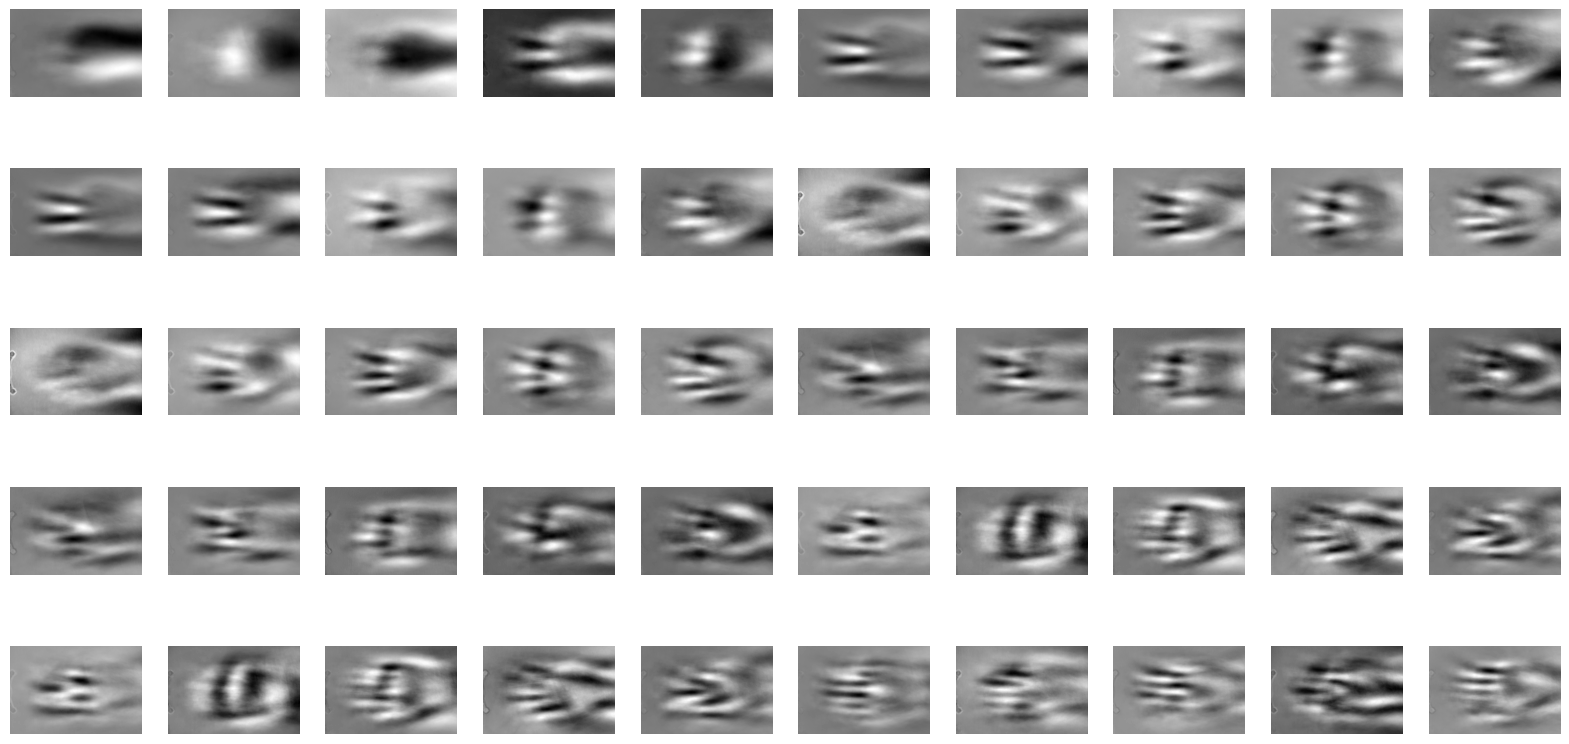

In [10]:
N,M = 5,10
fig, ax = plt.subplots(N, M, figsize=(20,10))
for i in range(N):
    for j in range(M):
        ax[i,j].imshow(pca_model.components_[N*i + j].reshape((200, 300)), cmap='gray')
        ax[i,j].axis('off')
plt.show()

# Training models

## Hyperparameter tuning

For each model we select hyperparameters that maximize mean accuracy measured by cross-validation on training set.

### KNN

#### Full images

In [11]:
knn_result = optimize_hyperparameters('knn', X_train, y_train, n_trials=100)
print(knn_result)

[I 2024-02-09 21:33:35,475] A new study created in memory with name: no-name-42bf6c5e-604e-4a91-845b-b643ed5b177f
[I 2024-02-09 21:33:45,426] Trial 6 finished with value: 0.8485714285714285 and parameters: {'n_neighbors': 30}. Best is trial 6 with value: 0.8485714285714285.
[I 2024-02-09 21:34:02,378] Trial 1 finished with value: 0.8754285714285714 and parameters: {'n_neighbors': 15}. Best is trial 1 with value: 0.8754285714285714.
[I 2024-02-09 21:34:02,398] Trial 11 finished with value: 0.8342857142857142 and parameters: {'n_neighbors': 39}. Best is trial 1 with value: 0.8754285714285714.
[I 2024-02-09 21:34:05,025] Trial 9 finished with value: 0.8354285714285714 and parameters: {'n_neighbors': 38}. Best is trial 1 with value: 0.8754285714285714.
[I 2024-02-09 21:34:05,062] Trial 10 finished with value: 0.8662857142857142 and parameters: {'n_neighbors': 21}. Best is trial 1 with value: 0.8754285714285714.
[I 2024-02-09 21:34:05,080] Trial 3 finished with value: 0.8262857142857143 and

FrozenTrial(number=21, state=1, values=[0.9114285714285716], datetime_start=datetime.datetime(2024, 2, 9, 21, 34, 5, 267176), datetime_complete=datetime.datetime(2024, 2, 9, 21, 34, 27, 479339), params={'n_neighbors': 3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_neighbors': IntDistribution(high=49, log=False, low=3, step=1)}, trial_id=21, value=None)


In [12]:
knn_result.params

{'n_neighbors': 3}

In [13]:
knn_result.value

0.9114285714285716

In [14]:
best_knn_model = KNeighborsClassifier(n_jobs=-1, **knn_result.params)

knn_score = cross_val_score(best_knn_model, X_train, y_train, n_jobs=-1, cv=10)
print('cross validation:')
print(f'mean: {knn_score.mean()}, std: {knn_score.std()}\n')

best_knn_model.fit(X_train, y_train)
print(f'test set: {best_knn_model.score(X_test, y_test)}')

cross validation:
mean: 0.9114285714285716, std: 0.016999399749306882

test set: 0.9223744292237442


#### Scaled images

In [15]:
knn_scaled_result = optimize_hyperparameters('knn', X_scaled_train, y_train, n_trials=100)
print(knn_scaled_result)

[I 2024-02-09 21:37:06,975] A new study created in memory with name: no-name-828a4db7-11ca-40f2-a58b-a633c3827a39
[I 2024-02-09 21:37:07,771] Trial 1 finished with value: 0.8965714285714286 and parameters: {'n_neighbors': 6}. Best is trial 1 with value: 0.8965714285714286.
[I 2024-02-09 21:37:08,486] Trial 3 finished with value: 0.8731428571428571 and parameters: {'n_neighbors': 17}. Best is trial 1 with value: 0.8965714285714286.
[I 2024-02-09 21:37:09,009] Trial 0 finished with value: 0.8280000000000001 and parameters: {'n_neighbors': 44}. Best is trial 1 with value: 0.8965714285714286.
[I 2024-02-09 21:37:09,502] Trial 4 finished with value: 0.8485714285714285 and parameters: {'n_neighbors': 30}. Best is trial 1 with value: 0.8965714285714286.
[I 2024-02-09 21:37:09,955] Trial 2 finished with value: 0.8617142857142858 and parameters: {'n_neighbors': 25}. Best is trial 1 with value: 0.8965714285714286.
[I 2024-02-09 21:37:10,427] Trial 6 finished with value: 0.8988571428571428 and pa

FrozenTrial(number=18, state=1, values=[0.9148571428571429], datetime_start=datetime.datetime(2024, 2, 9, 21, 37, 10, 873587), datetime_complete=datetime.datetime(2024, 2, 9, 21, 37, 16, 929327), params={'n_neighbors': 3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_neighbors': IntDistribution(high=49, log=False, low=3, step=1)}, trial_id=18, value=None)


In [16]:
knn_scaled_result.params

{'n_neighbors': 3}

In [17]:
knn_scaled_result.value

0.9148571428571429

In [18]:
best_knn_model_scaled = KNeighborsClassifier(n_jobs=-1, **knn_scaled_result.params)

knn_score_scaled = cross_val_score(best_knn_model_scaled, X_scaled_train, y_train, n_jobs=-1, cv=10)
print('cross validation:')
print(f'mean: {knn_score_scaled.mean()}, std: {knn_score_scaled.std()}\n')

best_knn_model_scaled.fit(X_scaled_train, y_train)
print(f'test set: {best_knn_model_scaled.score(X_scaled_test, y_test)}')

cross validation:
mean: 0.9148571428571429, std: 0.018507582560801893

test set: 0.9246575342465754


#### PCA

In [19]:
knn_pca_result = optimize_hyperparameters('knn', X_pca_train, y_train, n_trials=100)
print(knn_pca_result)

[I 2024-02-09 21:37:57,839] A new study created in memory with name: no-name-e4c52741-9a43-4337-a4ff-1993068525be
[I 2024-02-09 21:37:57,904] Trial 1 finished with value: 0.8325714285714285 and parameters: {'n_neighbors': 42}. Best is trial 1 with value: 0.8325714285714285.
[I 2024-02-09 21:37:57,979] Trial 6 finished with value: 0.8337142857142856 and parameters: {'n_neighbors': 41}. Best is trial 6 with value: 0.8337142857142856.
[I 2024-02-09 21:37:58,012] Trial 3 finished with value: 0.8577142857142857 and parameters: {'n_neighbors': 28}. Best is trial 3 with value: 0.8577142857142857.
[I 2024-02-09 21:37:58,024] Trial 5 finished with value: 0.8382857142857143 and parameters: {'n_neighbors': 36}. Best is trial 3 with value: 0.8577142857142857.
[I 2024-02-09 21:37:58,046] Trial 10 finished with value: 0.8382857142857143 and parameters: {'n_neighbors': 36}. Best is trial 3 with value: 0.8577142857142857.
[I 2024-02-09 21:37:58,054] Trial 2 finished with value: 0.8668571428571428 and 

FrozenTrial(number=21, state=1, values=[0.9165714285714286], datetime_start=datetime.datetime(2024, 2, 9, 21, 37, 58, 96368), datetime_complete=datetime.datetime(2024, 2, 9, 21, 37, 58, 226616), params={'n_neighbors': 3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_neighbors': IntDistribution(high=49, log=False, low=3, step=1)}, trial_id=21, value=None)


In [20]:
knn_pca_result.params

{'n_neighbors': 3}

In [21]:
knn_pca_result.value

0.9165714285714286

In [22]:
best_knn_model_pca = KNeighborsClassifier(n_jobs=-1, **knn_pca_result.params)

knn_score_pca = cross_val_score(best_knn_model_pca, X_pca_train, y_train, n_jobs=-1, cv=10)
print('cross validation:')
print(f'mean: {knn_score_pca.mean()}, std: {knn_score_pca.std()}\n')

best_knn_model_pca.fit(X_pca_train, y_train)
print(f'test set: {best_knn_model_pca.score(X_pca_test, y_test)}')

cross validation:
mean: 0.9165714285714286, std: 0.022598537066611652

test set: 0.9315068493150684


### Decision Tree

#### Scaled images

In [23]:
decision_tree_scaled_result = optimize_hyperparameters('decision_tree', X_scaled_train, y_train, n_trials=100)
print(decision_tree_scaled_result)

[I 2024-02-09 21:37:59,762] A new study created in memory with name: no-name-82f8a20f-21ed-437f-a895-e0b037da57e9
[I 2024-02-09 21:38:14,205] Trial 2 finished with value: 0.8142857142857143 and parameters: {'max_depth': 7, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_leaf_nodes': 19}. Best is trial 2 with value: 0.8142857142857143.
[I 2024-02-09 21:38:25,912] Trial 0 finished with value: 0.812 and parameters: {'max_depth': 25, 'min_samples_split': 19, 'min_samples_leaf': 11, 'max_leaf_nodes': 19}. Best is trial 2 with value: 0.8142857142857143.
[I 2024-02-09 21:38:39,450] Trial 1 finished with value: 0.8177142857142856 and parameters: {'max_depth': 12, 'min_samples_split': 29, 'min_samples_leaf': 2, 'max_leaf_nodes': 25}. Best is trial 1 with value: 0.8177142857142856.
[I 2024-02-09 21:38:49,824] Trial 4 finished with value: 0.7834285714285714 and parameters: {'max_depth': 17, 'min_samples_split': 25, 'min_samples_leaf': 13, 'max_leaf_nodes': 13}. Best is trial 1 with value: 0.

FrozenTrial(number=84, state=1, values=[0.8245714285714285], datetime_start=datetime.datetime(2024, 2, 9, 21, 50, 52, 263514), datetime_complete=datetime.datetime(2024, 2, 9, 21, 53, 13, 468905), params={'max_depth': 25, 'min_samples_split': 23, 'min_samples_leaf': 6, 'max_leaf_nodes': 25}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=30, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=40, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=20, log=False, low=1, step=1), 'max_leaf_nodes': IntDistribution(high=30, log=False, low=3, step=1)}, trial_id=84, value=None)


In [24]:
decision_tree_scaled_result.params

{'max_depth': 25,
 'min_samples_split': 23,
 'min_samples_leaf': 6,
 'max_leaf_nodes': 25}

In [25]:
decision_tree_scaled_result.value

0.8245714285714285

In [26]:
best_decision_tree_model_scaled = DecisionTreeClassifier(**decision_tree_scaled_result.params)

decision_tree_score_scaled = cross_val_score(best_decision_tree_model_scaled, X_scaled_train, y_train, n_jobs=-1, cv=10)
print('cross validation:')
print(f'mean: {decision_tree_score_scaled.mean()}, std: {decision_tree_score_scaled.std()}\n')

best_decision_tree_model_scaled.fit(X_scaled_train, y_train)
print(f'test set: {best_decision_tree_model_scaled.score(X_scaled_test, y_test)}')

cross validation:
mean: 0.8228571428571427, std: 0.03909172886054187

test set: 0.8493150684931506


#### PCA

In [27]:
decision_tree_pca_result = optimize_hyperparameters('decision_tree', X_pca_train, y_train, n_trials=1000)
print(decision_tree_pca_result)

[I 2024-02-09 21:56:29,228] A new study created in memory with name: no-name-8f2eda44-633b-4eab-8d43-54936ef5d45e
[I 2024-02-09 21:56:29,694] Trial 1 finished with value: 0.7485714285714286 and parameters: {'max_depth': 17, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_leaf_nodes': 27}. Best is trial 1 with value: 0.7485714285714286.
[I 2024-02-09 21:56:30,014] Trial 0 finished with value: 0.7485714285714286 and parameters: {'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_leaf_nodes': 28}. Best is trial 1 with value: 0.7485714285714286.
[I 2024-02-09 21:56:30,216] Trial 2 finished with value: 0.7497142857142857 and parameters: {'max_depth': 15, 'min_samples_split': 40, 'min_samples_leaf': 2, 'max_leaf_nodes': 22}. Best is trial 2 with value: 0.7497142857142857.
[I 2024-02-09 21:56:30,527] Trial 3 finished with value: 0.744 and parameters: {'max_depth': 8, 'min_samples_split': 16, 'min_samples_leaf': 15, 'max_leaf_nodes': 19}. Best is trial 2 with value: 0.74

FrozenTrial(number=596, state=1, values=[0.76], datetime_start=datetime.datetime(2024, 2, 9, 21, 58, 56, 619575), datetime_complete=datetime.datetime(2024, 2, 9, 21, 58, 59, 736399), params={'max_depth': 10, 'min_samples_split': 16, 'min_samples_leaf': 11, 'max_leaf_nodes': 30}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=30, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=40, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=20, log=False, low=1, step=1), 'max_leaf_nodes': IntDistribution(high=30, log=False, low=3, step=1)}, trial_id=596, value=None)


In [28]:
decision_tree_pca_result.params

{'max_depth': 10,
 'min_samples_split': 16,
 'min_samples_leaf': 11,
 'max_leaf_nodes': 30}

In [29]:
decision_tree_pca_result.value

0.76

In [30]:
best_decision_tree_model_pca = DecisionTreeClassifier(**decision_tree_pca_result.params)

decision_tree_score_pca = cross_val_score(best_decision_tree_model_pca, X_pca_train, y_train, n_jobs=-1, cv=10)
print('cross validation:')
print(f'mean: {decision_tree_score_pca.mean()}, std: {decision_tree_score_pca.std()}\n')

best_decision_tree_model_pca.fit(X_pca_train, y_train)
print(f'test set: {best_decision_tree_model_pca.score(X_pca_test, y_test)}')

cross validation:
mean: 0.76, std: 0.025809348092882788

test set: 0.7899543378995434


### Random Forest

#### Scaled images

In [31]:
random_forest_scaled_result = optimize_hyperparameters('random_forest', X_scaled_train, y_train, n_trials=100)
print(random_forest_scaled_result)

[I 2024-02-09 22:00:43,052] A new study created in memory with name: no-name-1c8d398f-f657-4429-b3d0-cd2070e8a67d
[I 2024-02-09 22:01:13,634] Trial 0 finished with value: 0.9137142857142857 and parameters: {'n_estimators': 364, 'max_depth': 37, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_leaf_nodes': 23}. Best is trial 0 with value: 0.9137142857142857.
[I 2024-02-09 22:01:32,673] Trial 2 finished with value: 0.9148571428571428 and parameters: {'n_estimators': 290, 'max_depth': 38, 'min_samples_split': 12, 'min_samples_leaf': 15, 'max_leaf_nodes': 59}. Best is trial 2 with value: 0.9148571428571428.
[I 2024-02-09 22:01:55,534] Trial 3 finished with value: 0.9097142857142856 and parameters: {'n_estimators': 318, 'max_depth': 26, 'min_samples_split': 26, 'min_samples_leaf': 20, 'max_leaf_nodes': 64}. Best is trial 2 with value: 0.9148571428571428.
[I 2024-02-09 22:02:24,556] Trial 1 finished with value: 0.9057142857142857 and parameters: {'n_estimators': 484, 'max_depth': 33, 'min

FrozenTrial(number=83, state=1, values=[0.9462857142857143], datetime_start=datetime.datetime(2024, 2, 9, 22, 52, 25, 851303), datetime_complete=datetime.datetime(2024, 2, 9, 23, 3, 27, 382501), params={'n_estimators': 586, 'max_depth': 46, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_leaf_nodes': 68}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=70, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=40, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=20, log=False, low=1, step=1), 'max_leaf_nodes': IntDistribution(high=70, log=False, low=3, step=1)}, trial_id=83, value=None)


In [32]:
random_forest_scaled_result.params

{'n_estimators': 586,
 'max_depth': 46,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_leaf_nodes': 68}

In [33]:
random_forest_scaled_result.value

0.9462857142857143

In [34]:
best_random_forest_model_scaled = RandomForestClassifier(**random_forest_scaled_result.params)

random_forest_score_scaled = cross_val_score(best_random_forest_model_scaled, X_scaled_train, y_train, n_jobs=-1, cv=10)
print('cross validation:')
print(f'mean: {random_forest_score_scaled.mean()}, std: {random_forest_score_scaled.std()}\n')

best_random_forest_model_scaled.fit(X_scaled_train, y_train)
print(f'test set: {best_random_forest_model_scaled.score(X_scaled_test, y_test)}')

cross validation:
mean: 0.9428571428571427, std: 0.018070158058105006

test set: 0.954337899543379


#### PCA

In [35]:
random_forest_pca_result = optimize_hyperparameters('random_forest', X_pca_train, y_train, n_trials=100)
print(random_forest_pca_result)

[I 2024-02-09 23:16:13,319] A new study created in memory with name: no-name-de84d4db-2448-445a-8974-b55eb65feab1
[I 2024-02-09 23:16:19,013] Trial 2 finished with value: 0.8462857142857143 and parameters: {'n_estimators': 405, 'max_depth': 52, 'min_samples_split': 31, 'min_samples_leaf': 10, 'max_leaf_nodes': 18}. Best is trial 2 with value: 0.8462857142857143.
[I 2024-02-09 23:16:26,330] Trial 0 finished with value: 0.8651428571428571 and parameters: {'n_estimators': 552, 'max_depth': 43, 'min_samples_split': 38, 'min_samples_leaf': 13, 'max_leaf_nodes': 40}. Best is trial 0 with value: 0.8651428571428571.
[I 2024-02-09 23:16:31,802] Trial 1 finished with value: 0.8571428571428571 and parameters: {'n_estimators': 417, 'max_depth': 47, 'min_samples_split': 32, 'min_samples_leaf': 10, 'max_leaf_nodes': 29}. Best is trial 0 with value: 0.8651428571428571.
[I 2024-02-09 23:16:35,711] Trial 3 finished with value: 0.8365714285714285 and parameters: {'n_estimators': 536, 'max_depth': 69, 'm

FrozenTrial(number=32, state=1, values=[0.8862857142857143], datetime_start=datetime.datetime(2024, 2, 9, 23, 18, 31, 544650), datetime_complete=datetime.datetime(2024, 2, 9, 23, 20, 41, 1744), params={'n_estimators': 701, 'max_depth': 60, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_leaf_nodes': 70}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=70, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=40, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=20, log=False, low=1, step=1), 'max_leaf_nodes': IntDistribution(high=70, log=False, low=3, step=1)}, trial_id=32, value=None)


In [36]:
random_forest_pca_result.params

{'n_estimators': 701,
 'max_depth': 60,
 'min_samples_split': 9,
 'min_samples_leaf': 2,
 'max_leaf_nodes': 70}

In [37]:
random_forest_pca_result.value

0.8862857142857143

In [38]:
best_random_forest_model_pca = RandomForestClassifier(**random_forest_pca_result.params)

random_forest_score_pca = cross_val_score(best_random_forest_model_pca, X_pca_train, y_train, n_jobs=-1, cv=10)
print('cross validation:')
print(f'mean: {random_forest_score_pca.mean()}, std: {random_forest_score_pca.std()}\n')

best_random_forest_model_pca.fit(X_pca_train, y_train)
print(f'test set: {best_random_forest_model_pca.score(X_pca_test, y_test)}')

cross validation:
mean: 0.8822857142857142, std: 0.021563385444700815

test set: 0.9200913242009132


### SVM

#### PCA

In [39]:
svm_pca_result = optimize_hyperparameters('svm', X_pca_train, y_train, n_trials=500)
print(svm_pca_result)

[I 2024-02-09 23:29:49,599] A new study created in memory with name: no-name-8e7f4340-9dfa-4bae-95ee-1c199264d4ab
[I 2024-02-09 23:29:50,321] Trial 2 finished with value: 0.7525714285714284 and parameters: {'C': 71.40407978875923, 'kernel': 'poly', 'gamma': 0.15647556747160166, 'degree': 7}. Best is trial 2 with value: 0.7525714285714284.
[I 2024-02-09 23:29:50,966] Trial 4 finished with value: 0.8382857142857143 and parameters: {'C': 76.05722826947334, 'kernel': 'poly', 'gamma': 0.7624623252335698, 'degree': 6}. Best is trial 4 with value: 0.8382857142857143.
[I 2024-02-09 23:29:51,349] Trial 0 finished with value: 0.9005714285714286 and parameters: {'C': 29.11732244278587, 'kernel': 'poly', 'gamma': 0.3302623528022888, 'degree': 3}. Best is trial 0 with value: 0.9005714285714286.
[I 2024-02-09 23:29:51,806] Trial 1 finished with value: 0.7525714285714284 and parameters: {'C': 22.19916797478827, 'kernel': 'poly', 'gamma': 0.4999516539979084, 'degree': 7}. Best is trial 0 with value: 0

FrozenTrial(number=6, state=1, values=[0.938857142857143], datetime_start=datetime.datetime(2024, 2, 9, 23, 29, 49, 609883), datetime_complete=datetime.datetime(2024, 2, 9, 23, 29, 51, 826524), params={'C': 37.909888023620276, 'kernel': 'poly', 'gamma': 0.5994495239810973, 'degree': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'C': FloatDistribution(high=100.0, log=False, low=0.05, step=None), 'kernel': CategoricalDistribution(choices=('poly',)), 'gamma': FloatDistribution(high=1.0, log=False, low=1e-05, step=None), 'degree': IntDistribution(high=9, log=False, low=2, step=1)}, trial_id=6, value=None)


In [40]:
svm_pca_result.params

{'C': 37.909888023620276,
 'kernel': 'poly',
 'gamma': 0.5994495239810973,
 'degree': 2}

In [41]:
svm_pca_result.value

0.938857142857143

In [42]:
best_svm_model_pca = SVC(**svm_pca_result.params)

svm_score_pca = cross_val_score(best_svm_model_pca, X_pca_train, y_train, n_jobs=-1, cv=10)
print('cross validation:')
print(f'mean: {svm_score_pca.mean()}, std: {svm_score_pca.std()}\n')

best_svm_model_pca.fit(X_pca_train, y_train)
print(f'test set: {best_svm_model_pca.score(X_pca_test, y_test)}')

cross validation:
mean: 0.938857142857143, std: 0.009231711097944878

test set: 0.9474885844748858


### XGBoost

#### PCA

In [43]:
xgboost_pca_result = optimize_hyperparameters('xgboost', X_pca_train, y_train, n_trials=100)
print(xgboost_pca_result)

[I 2024-02-09 23:31:52,683] A new study created in memory with name: no-name-5753bebf-3bd3-477f-96c4-6d895b17edcd
[I 2024-02-09 23:32:14,625] Trial 1 finished with value: 0.8971428571428571 and parameters: {'max_depth': 5, 'n_estimators': 183, 'learning_rate': 0.10699060449567811, 'subsample': 0.8409703403182744, 'reg_alpha': 2.27822285539933, 'reg_lambda': 3.8801895125106234}. Best is trial 1 with value: 0.8971428571428571.
[I 2024-02-09 23:32:31,473] Trial 0 finished with value: 0.8897142857142859 and parameters: {'max_depth': 5, 'n_estimators': 201, 'learning_rate': 0.13311287060012167, 'subsample': 0.6816673457893456, 'reg_alpha': 3.595325188593155, 'reg_lambda': 4.895345479133016}. Best is trial 1 with value: 0.8971428571428571.
[I 2024-02-09 23:33:08,444] Trial 2 finished with value: 0.8668571428571429 and parameters: {'max_depth': 5, 'n_estimators': 259, 'learning_rate': 0.012655108360423203, 'subsample': 0.8253313272775253, 'reg_alpha': 0.5993662331520067, 'reg_lambda': 2.31141

FrozenTrial(number=38, state=1, values=[0.9137142857142857], datetime_start=datetime.datetime(2024, 2, 9, 23, 42, 14, 152486), datetime_complete=datetime.datetime(2024, 2, 9, 23, 48, 12, 290069), params={'max_depth': 8, 'n_estimators': 243, 'learning_rate': 0.12043500993879998, 'subsample': 0.8527819687174611, 'reg_alpha': 0.04042958834661675, 'reg_lambda': 3.4022504268553266}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=12, log=False, low=3, step=1), 'n_estimators': IntDistribution(high=300, log=False, low=50, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.01, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'reg_alpha': FloatDistribution(high=5.0, log=False, low=0.0, step=None), 'reg_lambda': FloatDistribution(high=5.0, log=False, low=0.0, step=None)}, trial_id=38, value=None)


In [44]:
xgboost_pca_result.params

{'max_depth': 8,
 'n_estimators': 243,
 'learning_rate': 0.12043500993879998,
 'subsample': 0.8527819687174611,
 'reg_alpha': 0.04042958834661675,
 'reg_lambda': 3.4022504268553266}

In [45]:
xgboost_pca_result.value

0.9137142857142857

In [46]:
best_xgboost_model_pca = XGBClassifier(**xgboost_pca_result.params)

xgboost_score_pca = cross_val_score(best_xgboost_model_pca, X_pca_train, y_train, n_jobs=-1, cv=10)
print('cross validation:')
print(f'mean: {xgboost_score_pca.mean()}, std: {xgboost_score_pca.std()}\n')

best_xgboost_model_pca.fit(X_pca_train, y_train)
print(f'test set: {best_xgboost_model_pca.score(X_pca_test, y_test)}')

cross validation:
mean: 0.9137142857142857, std: 0.01289201619734684

test set: 0.9406392694063926
